In [1]:
import tensorflow as tf
import tf_keras as keras
import os
import cv2
import numpy as np
import imghdr
from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [3]:
data_dir = "DrowsinessDetection/train"
os.listdir(data_dir)

['class', 'image', '_classes.csv']

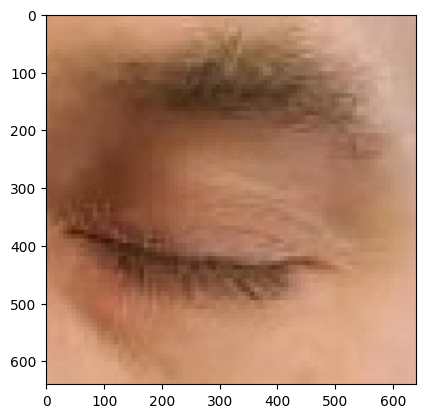

In [4]:
img = cv2.imread("DrowsinessDetection\\train\class\close\_13_jpg.rf.35c9428017020fffcc1707d3c7a8484c.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


Load Data:
- Batch size = 32


In [5]:
# tf.keras.utils.image_dataset_from_directory??

In [2]:
train_folder = 'DrowsinessDetection\\train\class'
test_folder = 'DrowsinessDetection\\test\class'
valid_folder = 'DrowsinessDetection\\valid\class'

data_train = keras.utils.image_dataset_from_directory(train_folder, batch_size=16, image_size=(128,128), color_mode='grayscale', label_mode='binary')
data_test = keras.utils.image_dataset_from_directory(test_folder, batch_size=16, image_size=(128,128),  color_mode='grayscale', label_mode='binary')
data_valid = keras.utils.image_dataset_from_directory(valid_folder, batch_size=16, image_size=(128,128),  color_mode='grayscale',  label_mode='binary')


Found 6238 files belonging to 2 classes.
Found 626 files belonging to 2 classes.
Found 1243 files belonging to 2 classes.


In [7]:
data_iterator = data_train.as_numpy_iterator()
batch = data_iterator.next()
batch[0]

array([[[[ 46.],
         [ 46.],
         [ 46.],
         ...,
         [ 93.],
         [ 94.],
         [ 96.]],

        [[ 46.],
         [ 46.],
         [ 46.],
         ...,
         [ 96.],
         [ 96.],
         [ 98.]],

        [[ 45.],
         [ 45.],
         [ 44.],
         ...,
         [ 99.],
         [ 99.],
         [ 99.]],

        ...,

        [[ 39.],
         [ 39.],
         [ 40.],
         ...,
         [ 75.],
         [ 76.],
         [ 78.]],

        [[ 38.],
         [ 39.],
         [ 41.],
         ...,
         [ 75.],
         [ 77.],
         [ 77.]],

        [[ 38.],
         [ 39.],
         [ 41.],
         ...,
         [ 75.],
         [ 77.],
         [ 77.]]],


       [[[123.],
         [123.],
         [123.],
         ...,
         [ 72.],
         [ 69.],
         [ 69.]],

        [[123.],
         [123.],
         [123.],
         ...,
         [ 72.],
         [ 69.],
         [ 69.]],

        [[122.],
         [122.],
      

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


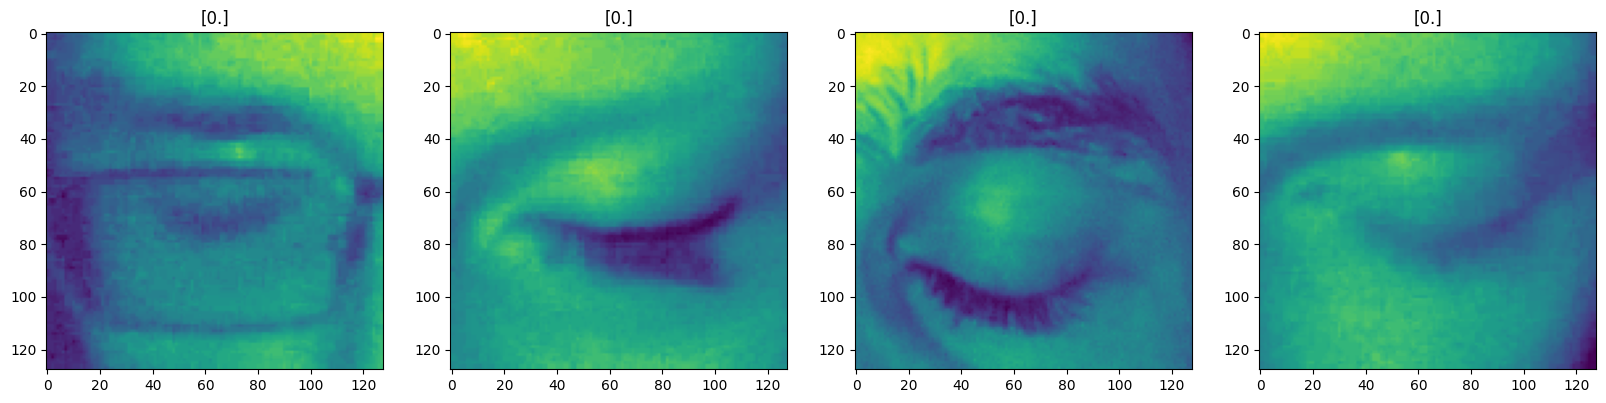

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# 0 = close
# 1 = open


Pre-processing:
- Normalization

In [9]:
data_train = data_train.map(lambda x,y: (x/255 , y))
data_test = data_test.map(lambda x,y: (x/255 , y))
data_valid = data_valid.map(lambda x,y: (x/255 , y))
batch = data_train.as_numpy_iterator().next()
batch[0].max()


1.0

Deep Model

In [3]:
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tf_keras.regularizers import l2, l1
from tf_keras.callbacks import EarlyStopping
from tf_keras.layers import BatchNormalization

In [11]:
brightness = RandomBrightness([-0.2, 0.2])
contrast = RandomContrast(0.2)
flip = RandomFlip("vertical")
rotate = RandomRotation(0.1)
zoom = RandomZoom(0.3)
translate = RandomTranslation(height_factor=0.2, width_factor=0.2)

In [12]:
model = Sequential()
model.add(contrast)
model.add(rotate)
model.add(zoom)
model.add(translate)

model.add(Conv2D(32,(3,3), 1,activation='relu', input_shape=(128,128, 3), padding='same')) # , kernel_regularizer=l2(0.001)
# model.add(BatchNormalization())
model.add(MaxPooling2D())
# model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), 1,activation='relu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D())
# model.add(Dropout(0.5))

# model.add(Conv2D(128,(3,3), 1,activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D())
# # model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu')) #
# model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001) , loss = keras.losses.BinaryCrossentropy() , metrics=['accuracy'])

In [14]:
for images, labels in data_train.take(1):
    model(images)
    break
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCon  (16, 128, 128, 1)         0         
 trast)                                                          
                                                                 
 random_rotation (RandomRot  (16, 128, 128, 1)         0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (16, 128, 128, 1)         0         
                                                                 
 random_translation (Random  (16, 128, 128, 1)         0         
 Translation)                                                    
                                                                 
 conv2d (Conv2D)             (16, 128, 128, 32)        320       
                                                        

Train the Model

In [15]:
logdir = 'logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(data_train, epochs= 10, validation_data=data_valid, callbacks=[tensorboard_callback])

Epoch 1/10


390/390 [==============================] - 269s 581ms/step - loss: 0.5545 - accuracy: 0.7336 - val_loss: 0.4105 - val_accuracy: 0.8504
Epoch 2/10
390/390 [==============================] - 200s 513ms/step - loss: 0.4384 - accuracy: 0.8091 - val_loss: 0.3030 - val_accuracy: 0.8656
Epoch 3/10
390/390 [==============================] - 203s 521ms/step - loss: 0.3861 - accuracy: 0.8314 - val_loss: 0.3074 - val_accuracy: 0.8697
Epoch 4/10
390/390 [==============================] - 205s 525ms/step - loss: 0.3216 - accuracy: 0.8641 - val_loss: 0.2711 - val_accuracy: 0.8890
Epoch 5/10
390/390 [==============================] - 225s 575ms/step - loss: 0.2870 - accuracy: 0.8807 - val_loss: 0.1505 - val_accuracy: 0.9485
Epoch 6/10
390/390 [==============================] - 215s 550ms/step - loss: 0.2393 - accuracy: 0.9030 - val_loss: 0.1374 - val_accuracy: 0.9469
Epoch 7/10
390/390 [==============================] - 201s 516ms/step - loss: 0.2285 - accuracy: 0.9118 - val_loss: 0.1638

Plot Performance

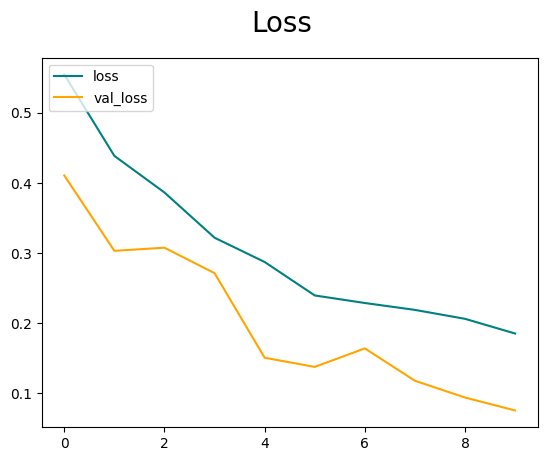

In [16]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color="orange", label='val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

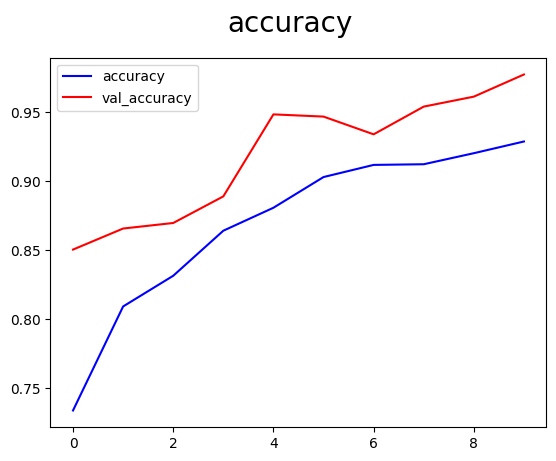

In [17]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color="red", label='val_accuracy')
fig.suptitle('accuracy', fontsize = 20)
plt.legend(loc="upper left")
plt.show()

Saving Model


In [ ]:
model.save(os.path.join('model', 'EyeClassifier.h5'))

In [4]:
from tf_keras.models import load_model
new_model = load_model(os.path.join('model', 'EyeClassifier.h5'))

Evaluate Performance

In [5]:
from tf_keras.metrics import Precision, Recall, BinaryAccuracy

In [6]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy ()

In [7]:
for batch in data_test.as_numpy_iterator():
    X, y = batch
    yhat = new_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 44ms/step
PrecisionL0.7190265655517578, Recall:0.9789156913757324, Bi Accuracy:0.7859424948692322, Accuracy:0.7028753757476807


Test


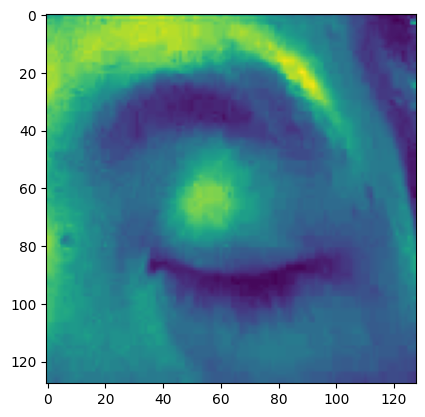

In [8]:
# img = cv2.imread("DrowsinessDetection\\test\class\close\_27_jpg.rf.e0c6085dbe4912f6d17da5fac6fb53be.jpg", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("DrowsinessDetection\\valid\class\open\_31_jpg.rf.2b2f35ebfb165e33d25203ad8f66640c.jpg", cv2.IMREAD_GRAYSCALE)

# NEW DATA
# img = cv2.imread("matabuka.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.imread("matatutup.jpg", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("openeye.jpeg", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("closedeye.jpg", cv2.IMREAD_GRAYSCALE)

img_with_channel = img[..., tf.newaxis]

# img = cv2.imread("test.jpg")
resize = tf.image.resize(img_with_channel, (128, 128))
plt.imshow(resize)

The Neural network expect to pass batch of images, not a single image
need to encapsulate it inside of another set of parentheses

In [9]:
resize.shape

TensorShape([128, 128, 1])

In [10]:
np.expand_dims(resize,0).shape

(1, 128, 128, 1)

In [12]:
yhat = new_model.predict(np.expand_dims(resize,0))
yhat
if yhat > 0.5:
    print(f'Predicted Eyes open {yhat}')
else:
    print(f'Predicted Eyes close {yhat}')


1/1 [==============================] - 0s 244ms/step
Predicted Eyes close [[7.1039674e-11]]
